# Space objects practice|

In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import concurrent
from concurrent.futures import ProcessPoolExecutor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid
import lightgbm as lgb
from lightgbm import LGBMClassifier


In [2]:
ORIGINAL_PATH = 'data_original.csv'
FILTRATED_PATH = 'data_filtrated.csv'
PROCESSED_PATH = 'data_processed.csv'
INPUT_PATH = 'data_input.csv'
PREDICTED_PATH = 'data_predicted.csv'

In [3]:
df_orig = pd.read_csv(ORIGINAL_PATH)

In [4]:
df_filt = df_orig.drop(columns=['Row_id', 'rerun_ID'])

In [5]:
class_labels = {'GALAXY': 0, 'STAR': 1, 'QSO': 2}
reversed_labels = dict(zip(class_labels.values(), class_labels.keys()))

In [6]:
df_filt['class'] = df_filt['class'].replace(class_labels)

In [7]:
df_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89999 entries, 0 to 89998
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   obj_ID       89999 non-null  float64
 1   alpha        89999 non-null  float64
 2   delta        89999 non-null  float64
 3   u            89999 non-null  float64
 4   g            89999 non-null  float64
 5   r            89999 non-null  float64
 6   i            89999 non-null  float64
 7   z            89999 non-null  float64
 8   run_ID       89999 non-null  int64  
 9   cam_col      89999 non-null  int64  
 10  field_ID     89999 non-null  int64  
 11  spec_obj_ID  89999 non-null  float64
 12  class        89999 non-null  int64  
 13  redshift     89999 non-null  float64
 14  plate        89999 non-null  int64  
 15  MJD          89999 non-null  int64  
 16  fiber_ID     89999 non-null  int64  
dtypes: float64(10), int64(7)
memory usage: 11.7 MB


In [8]:
class_data = {}
for class_label in class_labels:
    class_data[class_label] = df_filt[df_filt['class'] == class_labels[class_label]]

In [9]:
for class_label in class_labels:
    X = class_data[class_label].drop(columns=['class'])
    clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    y_pred = clf.fit_predict(X)
    anomalies = X[y_pred == -1]
    print(f"Anomalies in class {class_label}:")
    print(anomalies)
    df_filt = df_filt[~df_filt.index.isin(anomalies.index)]

Anomalies in class GALAXY:
             obj_ID       alpha      delta         u         g         r  \
20     1.237652e+18  171.975425  67.747450  22.13367  20.84772  18.96537   
61     1.237662e+18  252.654652  19.732789  25.19646  21.77507  20.79209   
65     1.237662e+18  254.353300  18.296474  20.64171  18.76100  17.38466   
67     1.237662e+18  252.410933  19.757336  22.08841  19.65585  18.15532   
70     1.237680e+18  332.761322  19.258640  22.11101  19.30047  17.96690   
...             ...         ...        ...       ...       ...       ...   
89919  1.237652e+18  207.747789   1.156031  22.39501  21.30981  19.47198   
89923  1.237668e+18  157.394200  22.069019  23.81636  22.59339  20.86486   
89947  1.237679e+18  358.747375  24.727359  24.06134  21.23081  19.37044   
89957  1.237664e+18  136.677235   9.080618  22.58019  22.25608  20.59716   
89958  1.237664e+18  131.625010   8.108288  22.54009  21.05508  19.33536   

              i         z  run_ID  cam_col  field_ID   spec_

In [10]:
df_filt = df_filt.reset_index(drop=True)

In [11]:
def show_statistics(df):
    grouped_data = df.groupby('class')

    num_columns = len(df.columns) - 1
    num_rows = int(np.ceil(num_columns / 2))
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))

    for i, column in enumerate(df.columns[1:]):
        row = i // 2
        col = i % 2
        ax = axs[row, col]
        
        for class_label, class_data in grouped_data:
            sns.histplot(data=class_data, x=column, label=class_label, ax=ax)
        
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.legend()

    plt.tight_layout()

    plt.show()

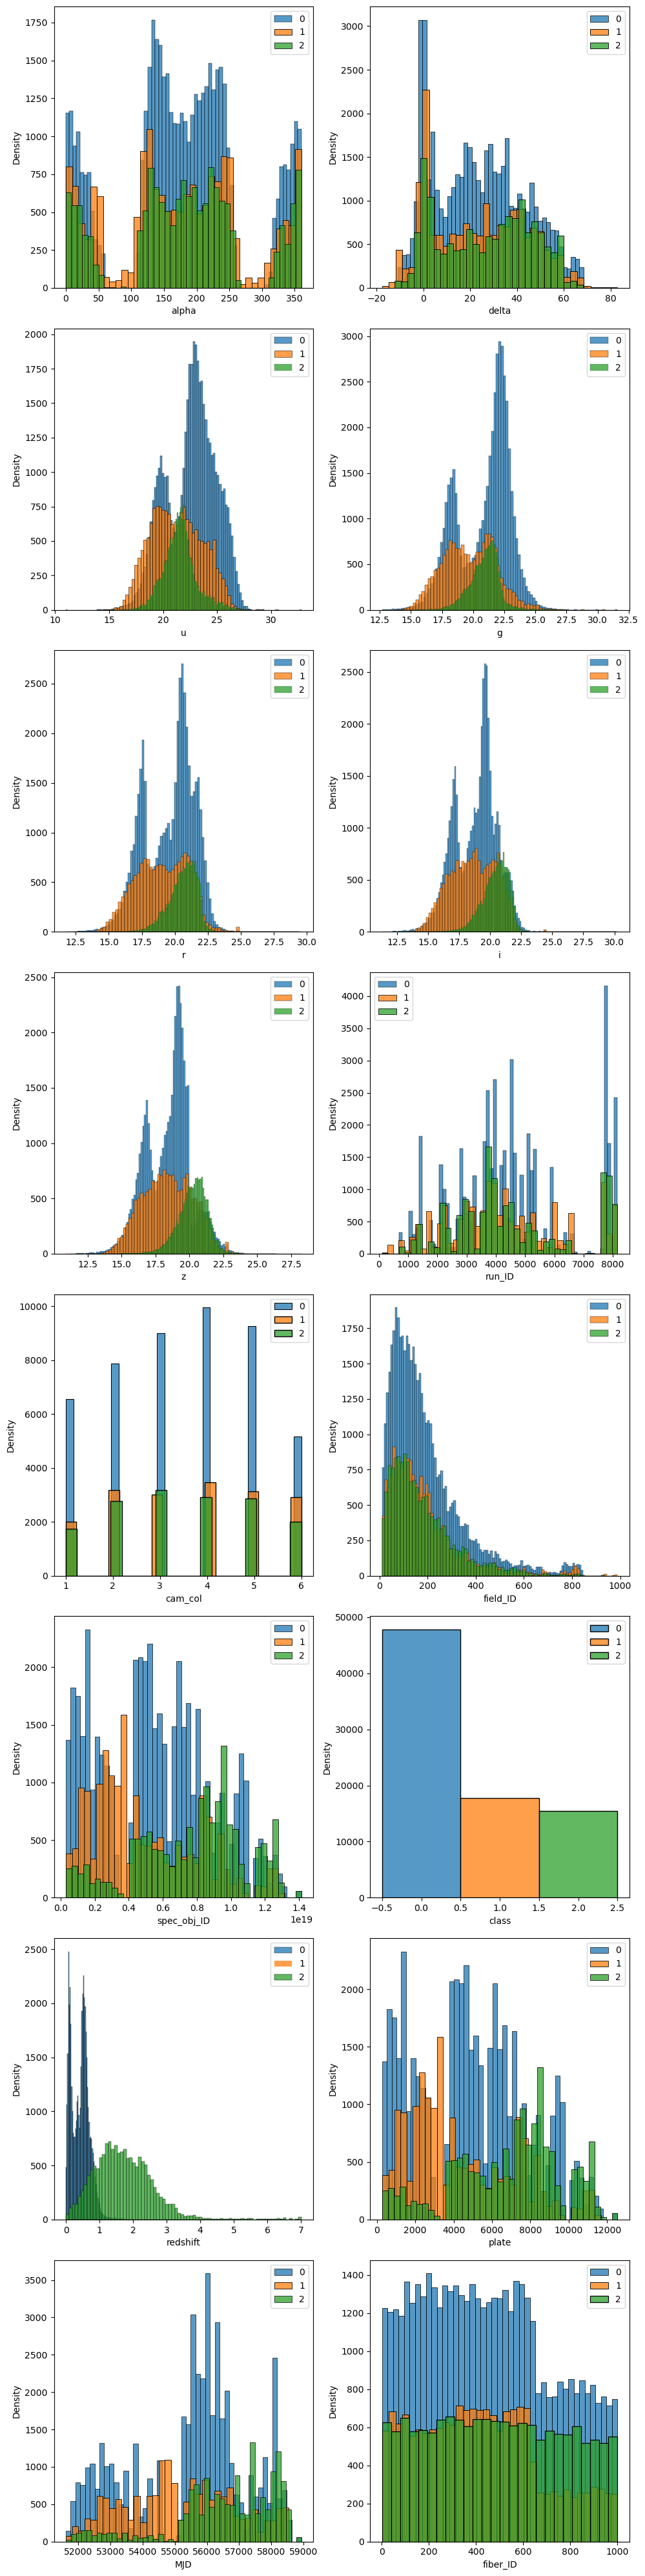

In [12]:
show_statistics(df_filt)

In [13]:
df_filt.to_csv(FILTRATED_PATH, index=False)

In [14]:
model = LGBMClassifier()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df_filt.drop(columns=['class']), df_filt['class'], test_size=0.2, random_state=42
    )

In [16]:
hyperparams = {
    'verbosity': [-1],
    'num_class': [3],
    'num_leaves': [62, 127],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 200],
    'max_depth': [-1]
}